# <b>Projekt 2. - Wykrywanie naczyń dna siatkówki oka</b>
### <b>Autorzy:</b> Wiktoria Białasik 151436, Mateusz Czechowski 155921

## <u>Zastosowany język programowania oraz użyte biblioteki</u>
<p> W projekcie wykorzystano język programowania <b>Python</b> oraz posłużono się bibliotekami wymienionymi poniżej. 

In [4]:
import os
import ipywidgets as widgets
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import frangi
from IPython.display import display, clear_output

### Odczyt oraz wyświetlenie obrazu wejściwego - zdjęcia siatkówki oka

Dropdown(description='Pick image', index=1, options=('10_bad.JPG', '10_good.JPG', '11_bad.JPG', '11_good.JPG',…

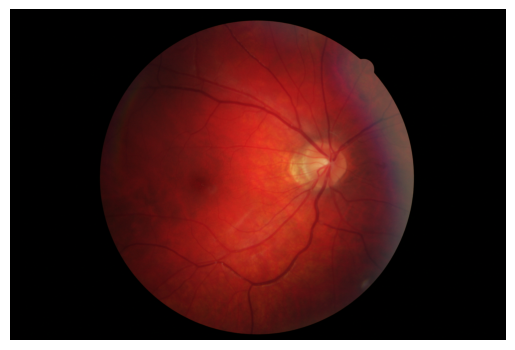

In [5]:
image = None
filename = ''
dir = './input-data/'
examples_list = [file for file in os.listdir(dir) ]

filename_picker = widgets.Dropdown(
    options=examples_list,
    description="Pick image",
    disabled=False
)

def show(change):
    global image, filename
    clear_output(wait=True)
    display(filename_picker)
    selected_file = change['new']
    
    if selected_file:
        file_path = os.path.join(dir, selected_file)
    
        image = mpimg.imread(file_path)
        if len(image.shape) == 3:
            plt.imshow(image) 
            plt.axis('off')
            plt.show()
            image = np.mean(image, axis=2)

        filename = os.path.splitext(filename_picker.value)[0]
        print(filename)

filename_picker.observe(show, names='value')
display(filename_picker)


### Wstępne przetwarzanie obrazu

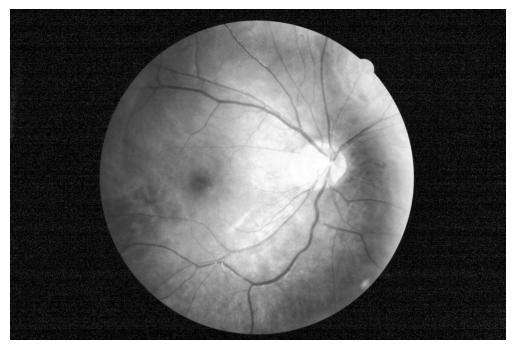

In [22]:
def preprocess_image(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = image.astype(np.uint8)

    image = cv2.equalizeHist(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    blured_image = cv2.GaussianBlur(image, (5, 5), 0)

    return blured_image 

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

blured_image = preprocess_image(image)
show_image(blured_image) 


### Właściwe przetwarzanie obrazu - Filtr Frangiego

In [ ]:
def frangi_filter(image, threshold=0.1, to_255=True):
    image = image.astype(np.float64) / 255.0
    frangi_result = frangi(image)
    binary_mask = (frangi_result > threshold).astype(np.uint8)

    return binary_mask

vessel_mask = frangi_filter(blured_image)
show_image(vessel_mask)

result = frangi(blured_image.astype(np.float64) / 255.0)
show_image(result)

### Końcowe przetwarzanie - oczyszczanie maski

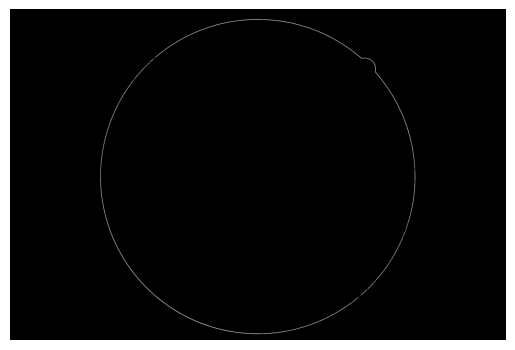

In [46]:
def postprocess_mask(mask):
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    return cleaned

postprocessed_mask = postprocess_mask(vessel_mask)
show_image(postprocessed_mask)

### Nakłądanie konturów na oryginalny obraz

In [50]:
def visualize_mask(original, mask):
    overlay = original.copy()
    overlay[mask == 1] = [255, 0, 0]  # kolor czerwony dla naczyń
    return overlay

vis = visualize_mask(image, postprocessed_mask)
show_image(vis)

ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 26909 output values where the mask is true